In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
import emcee
import sys
%matplotlib inline

In [2]:
b = phoebe.default_binary()

In [3]:
b.add_constraint('semidetached', 'primary')

<ParameterSet: 1 parameters>

In [4]:
b.add_constraint('semidetached', 'secondary')

<ParameterSet: 1 parameters>

In [5]:
b['period@orbit'] = 1
b['sma@orbit'] = 6
#b['q@binary'] = 0.44
# b['incl@orbit'] = 83.5
# b['requiv@primary'] = 1.2
# b['requiv@secondary'] = 0.8
#b['teff@primary'] = 5660.
# b['teff@secondary'] = 5500.

In [6]:
lc = np.loadtxt('data.lc')

In [7]:
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=0.05*np.ones(len(lc)))

<ParameterSet: 78 parameters | contexts: compute, constraint, figure, dataset>

In [8]:
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()
b.set_value_all('irrad_method', 'none')

In [9]:
b.flip_constraint('compute_phases', 'compute_times')
b['compute_phases@lc@dataset'] = np.linspace(-0.5,0.5,21)

In [15]:
def lnprob(x, adjpars, priors):
    #Check to see that all values are within the allowed limits:
    if not np.all([priors[i][0] < x[i] < priors[i][1] for i in range(len(priors))]):
         return -np.inf

    for i in range(len(adjpars)):
        b[adjpars[i]] = x[i]
    
    # Let's assume that our priors are uniform on the range of the physical parameter combinations.
    # This is already handled in Phoebe, which will throw an error if the system is not physical,
    # therefore it's easy to implement the lnprior as =0 when system checks pass and =-inf if they don't.
    # Here we'll 'package' this in a simple try/except statement:
    
    try:
        b.run_compute(irrad_method='none')

        # sum of squares of the residuals
        fluxes_model = b['fluxes@model'].interp_value(times=lc[:,0])
        lnp = -0.5*np.sum((fluxes_model-b['value@fluxes@dataset'])**2 / b['value@sigmas@dataset']**2) 

    except:
        lnp = -np.inf

    sys.stderr.write("lnp = %e\n" % (lnp))

    return lnp

In [16]:
from scipy.stats import norm
def run(adjpars, priors, nwalkers, niter):
    ndim = len(adjpars)

   

    p0 = np.array([[p[0] + (p[1]-p[0])*np.random.rand() for p in priors] for i in range(nwalkers)])

#     pool = MPIPool()
#     if not pool.is_master():
#         pool.wait()
#         sys.exit(0)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[adjpars, priors])

    pos, prob, state = sampler.run_mcmc(p0, niter)
    
    print(p0)
    
    for i in range(ndim):
        plt.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = plt.hist(y, 200, density=1, color="b", alpha=0.45)
        plt.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)       
        print ("mu,", "sigma = ", mu, sigma)

        bf = norm.pdf(bins, mu, sigma)
        l = plt.plot(bins, bf, 'k--', linewidth=2.0)

    pl.show()
    
    return pos

#     pool.close()



100%|██████████| 21/21 [00:00<00:00, 27.59it/s]
lnp = -4.484679e+02
100%|██████████| 21/21 [00:03<00:00,  6.64it/s]
lnp = -9.838522e+03
100%|██████████| 21/21 [00:02<00:00,  9.46it/s]
lnp = -7.017594e+02
100%|██████████| 21/21 [00:02<00:00,  9.23it/s]
lnp = -1.906837e+03
100%|██████████| 21/21 [00:00<00:00, 29.92it/s]
lnp = -5.452190e+03
100%|██████████| 21/21 [00:02<00:00,  9.14it/s]
lnp = -2.823362e+02
100%|██████████| 21/21 [00:00<00:00, 27.98it/s]
lnp = -1.117694e+03
100%|██████████| 21/21 [00:00<00:00, 28.38it/s]
lnp = -3.000285e+02
100%|██████████| 21/21 [00:00<00:00, 27.84it/s]
lnp = -4.663568e+03
100%|██████████| 21/21 [00:00<00:00, 29.38it/s]
lnp = -3.181534e+03
100%|██████████| 21/21 [00:00<00:00, 29.36it/s]
lnp = -3.421245e+03
100%|██████████| 21/21 [00:02<00:00,  9.34it/s]
lnp = -2.842582e+02
100%|██████████| 21/21 [00:00<00:00, 26.85it/s]
lnp = -1.688966e+03
100%|██████████| 21/21 [00:00<00:00, 26.49it/s]
lnp = -1.804356e+02
100%|██████████| 21/21 [00:00<00:00, 28.20it/s]


100%|██████████| 21/21 [00:00<00:00, 27.79it/s]
lnp = -2.674135e+02
100%|██████████| 21/21 [00:00<00:00, 27.28it/s]
lnp = -2.059614e+02
100%|██████████| 21/21 [00:00<00:00, 25.77it/s]
lnp = -2.864594e+01
100%|██████████| 21/21 [00:02<00:00,  9.38it/s]
lnp = -1.439954e+02
100%|██████████| 21/21 [00:00<00:00, 27.53it/s]
lnp = -3.522994e+01
100%|██████████| 21/21 [00:02<00:00,  9.43it/s]
lnp = -1.914760e+03
100%|██████████| 21/21 [00:00<00:00, 28.46it/s]
lnp = -1.579203e+02
100%|██████████| 21/21 [00:02<00:00,  9.31it/s]
lnp = -1.966481e+03
100%|██████████| 21/21 [00:02<00:00,  9.22it/s]
lnp = -2.510841e+02
100%|██████████| 21/21 [00:02<00:00,  8.86it/s]
lnp = -3.021903e+02
100%|██████████| 21/21 [00:02<00:00,  9.30it/s]
lnp = -6.729010e+01
100%|██████████| 21/21 [00:02<00:00,  9.35it/s]
lnp = -6.341796e+01
100%|██████████| 21/21 [00:00<00:00, 27.81it/s]
lnp = -2.450356e+03
100%|██████████| 21/21 [00:00<00:00, 27.44it/s]
lnp = -2.115554e+02
100%|██████████| 21/21 [00:02<00:00,  9.05it/s]


100%|██████████| 21/21 [00:02<00:00,  9.15it/s]
lnp = -6.416169e+01
100%|██████████| 21/21 [00:00<00:00, 27.61it/s]
lnp = -7.252343e+01
100%|██████████| 21/21 [00:00<00:00, 27.52it/s]
lnp = -6.601937e+01
100%|██████████| 21/21 [00:02<00:00,  9.15it/s]
lnp = -1.325147e+02
100%|██████████| 21/21 [00:00<00:00, 28.14it/s]
lnp = -1.750492e+01
100%|██████████| 21/21 [00:00<00:00, 28.08it/s]
lnp = -2.925130e+02
100%|██████████| 21/21 [00:00<00:00, 27.34it/s]
lnp = -1.484416e+02
100%|██████████| 21/21 [00:00<00:00, 27.40it/s]
lnp = -1.505675e+01
100%|██████████| 21/21 [00:00<00:00, 28.29it/s]
lnp = -5.549129e+01
100%|██████████| 21/21 [00:00<00:00, 27.98it/s]
lnp = -4.893940e+02
100%|██████████| 21/21 [00:00<00:00, 27.71it/s]
lnp = -2.157016e+01
100%|██████████| 21/21 [00:00<00:00, 28.42it/s]
lnp = -5.060677e+02
100%|██████████| 21/21 [00:02<00:00,  9.26it/s]
lnp = -1.040565e+03
100%|██████████| 21/21 [00:00<00:00, 26.66it/s]
lnp = -1.396342e+02
100%|██████████| 21/21 [00:00<00:00, 27.84it/s]


[[7.81102857e+01 5.17658255e-01 5.41879356e+03 5.52985290e+03]
 [8.28619986e+01 8.50707178e-01 5.40680169e+03 5.72308854e+03]
 [7.78914018e+01 2.42665774e-01 5.59170351e+03 5.69998258e+03]
 [7.81262457e+01 5.97678886e-01 5.46779208e+03 5.68041718e+03]
 [7.79755200e+01 2.29295092e-02 5.43530392e+03 5.41486093e+03]
 [7.58576433e+01 5.44426152e-01 5.59159339e+03 5.56315161e+03]
 [7.64478225e+01 7.24967838e-01 5.53783041e+03 5.42375711e+03]
 [8.29071451e+01 3.87045299e-01 5.65247528e+03 5.52708929e+03]
 [7.70502590e+01 7.45615626e-01 5.55477244e+03 5.74863606e+03]
 [7.74760508e+01 8.62560871e-02 5.57409457e+03 5.62042966e+03]
 [7.69214330e+01 1.00245241e-01 5.75940413e+03 5.42721923e+03]
 [8.13413651e+01 3.22962571e-01 5.60625857e+03 5.66579116e+03]
 [8.06768198e+01 7.15003845e-01 5.42173083e+03 5.44097653e+03]
 [7.58732899e+01 3.56590538e-01 5.53983929e+03 5.51254076e+03]
 [7.97976349e+01 5.91702082e-01 5.68853064e+03 5.64391933e+03]
 [8.35913283e+01 4.65433767e-01 5.59894102e+03 5.732484

NameError: name 'pl' is not defined

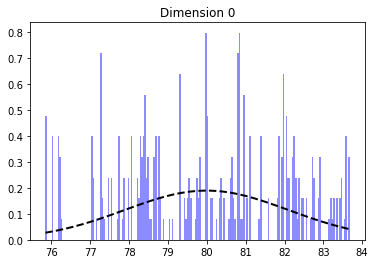

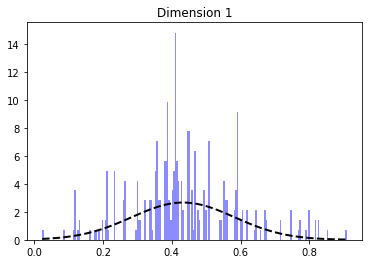

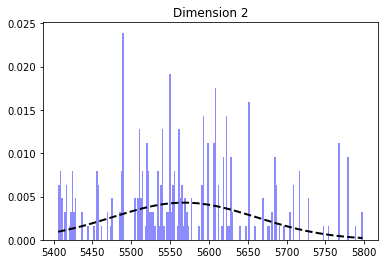

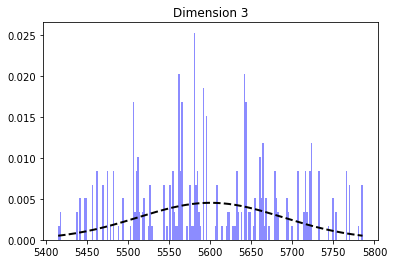

In [17]:
adjpars = ['incl@orbit', 'q@binary', 'teff@primary', 'teff@secondary']
priors = [(75.0, 84.0), (0, 1), (5400, 5800), (5400., 5800.)]
nwalkers = 32
niters = 10
state = None

import time

time1 = time.time()
postion = run(adjpars, priors, nwalkers, niters)
time2 = time.time()

In [ ]:
from matplotlib.pyplot import cm 

mod = b
position = postion
times = lc[:,0]
color=cm.rainbow(np.linspace(0,1,nwalkers))

for i,c in zip(range(nwalkers),color):
    
    mod['incl@binary@orbit@component'] = position[-1-i,0]
    mod['q@binary'] = position[-1-i,1]
    mod['teff@primary'] = position[-1-i,2]
    mod['teff@secondary'] = osition[-1-i,3]
    mod.run_compute(model='run{}'.format(i))


for i,c in zip(range(nwalkers),color):
    model = mod['fluxes@run{}'.format(i)].interp_value(times=times)

    #plt.figure(1)
    plt.plot(times,model,c=c)
plt.plot(times,lc[:,1],"k.")
plt.xlabel("Times")
plt.ylabel("Flux")
